# Set up -- just run all this stuff

In [1]:
from circuits.dictionary_learning.dictionary import AutoEncoder
import pickle
import os
import torch as t
from circuits.chess_utils import decode_list
from IPython.display import HTML
from circuits.chess_utils import pgn_string_to_board
from circuits.nnsight_buffer import NNsightActivationBuffer
from huggingface_hub import hf_hub_download
from circuits.utils import (
    chess_hf_dataset_to_generator,
    othello_hf_dataset_to_generator,
    get_model,
    get_submodule,
)

# download data from huggingface if needed
if not os.path.exists('chess_layer5'):
    hf_hub_download(repo_id='adamkarvonen/chess_saes', filename='chess_layer5.zip', local_dir='circuits')
    # unzip the data
    os.system('unzip circuits/chess_layer5.zip')


device = 'cuda:0'

/share/u/smarks/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/share/u/smarks/chess-gpt-circuits/.conda/lib/python3.11/site-packages/transformers/utils/generic.py:485: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/share/u/smarks/chess-gpt-circuits/.conda/lib/python3.11/site-packages/transformers/utils/generic.py:342: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
Matplotlib created a temporary cache directory at /tmp/matplotlib-rs6xkq9l because the default path (/share/u/smarks/.config/matplotlib) is not a writable directory; it is highly recommended 

In [2]:
# load SAE
ae_path = 'chess_layer5/ef=4_lr=1e-03_l1=1e-01_layer=5'
ae = AutoEncoder.from_pretrained(os.path.join(ae_path, 'ae.pt'), device='cuda:0')

# load information about features
with open(os.path.join(ae_path, 'indexing_find_dots_indices_n_inputs_10000_results_feature_labels.pkl'), 'rb') as f:
    results = pickle.load(f)

def to_device(d, device=device):
    if isinstance(d, t.Tensor):
        return d.to(device)
    if isinstance(d, dict):
        return {k: to_device(v, device) for k, v in d.items()}
results = to_device(results)



# load model
layer = 5
othello = False

if not othello:
    with open("models/meta.pkl", "rb") as f:
        meta = pickle.load(f)

    context_length = 256
    model_name = "adamkarvonen/8LayerChessGPT2"
    dataset_name = "adamkarvonen/chess_sae_text"
    data = chess_hf_dataset_to_generator(
        dataset_name, meta, context_length=context_length, split="train", streaming=True
    )
    model_type = "chess"
else:
    context_length = 59
    model_name = "Baidicoot/Othello-GPT-Transformer-Lens"
    dataset_name = "taufeeque/othellogpt"
    data = othello_hf_dataset_to_generator(
        dataset_name, context_length=context_length, split="train", streaming=True
    )
    model_type = "othello"

model = get_model(model_name, device)
submodule = get_submodule(model_name, layer, model)

# load data
activation_dim = 512  # output dimension of the layer
buffer = NNsightActivationBuffer(
    data,
    model,
    submodule,
    n_ctxs=8e3,
    ctx_len=context_length,
    refresh_batch_size=128,
    io="out",
    d_submodule=activation_dim,
    device=device,
)

/share/u/smarks/chess-gpt-circuits/.conda/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [36]:
# functions for visualizing PNG string
def shade(value, max_value):
    if abs(value) > max_value:
        raise ValueError("Absolute value must be less than or equal to max_value.")
    
    normalized_value = value / max_value
    
    if normalized_value < 0:
        # Red shade for negative values
        red = 255
        green = int(255 * (1 + normalized_value))
        blue = int(255 * (1 + normalized_value))
    else:
        # Blue shade for positive values
        red = int(255 * (1 - normalized_value))
        green = int(255 * (1 - normalized_value))
        blue = 255
    
    # White color for zero value
    if value == 0:
        red = green = blue = 255
    
    # Convert RGB values to hex color code
    hex_color = "#{:02x}{:02x}{:02x}".format(red, green, blue)
    
    return hex_color

def visualize_pgn(tokens, meta, activations, max_value, prefix=''):
    html_elements = []
    for token, act in zip(tokens, activations):
        hex_color = shade(act, max_value)
        s = decode_list(meta, [token])[0]
        s = s.replace(' ', '&nbsp;')
        html_element = f'<span style="background-color: {hex_color}; color: black">{s}</span>'
        html_elements.append(html_element)
    
    combined_html = ''.join(html_elements)
    combined_html = prefix + combined_html
    return HTML(combined_html)

In [55]:
# visualize top k max activating contexts for given feature
def visualize(model, ae, buffer, feat_idx, k=20):
    tokens = buffer.token_batch()
    with model.trace(tokens):
        embeds = model.transformer.wte.output.save()
        embeds.retain_grad()
        x = submodule.output[0]
        f = ae.encode(x).save()
    mean_embed = embeds.value.mean(dim=(0,1))
    f = f.value[...,feat_idx]

    # get indices of top k exemplars
    flattened_f = f.flatten()
    top_values, top_indices_flattened = t.topk(flattened_f, k)
    top_indices = t.unravel_index(top_indices_flattened, f.shape)
    top_values.sum().backward()

    # compile top contexts and activations
    contexts, activations, attributions = [], [], []
    for i in range(k):
        context_idx, token_idx = top_indices[0][i].item(), top_indices[1][i].item()
        contexts.append(tokens[context_idx, :token_idx+1].tolist())
        activations.append(f[context_idx, :token_idx+1].tolist())
        attributions.append(
            (embeds.value.grad * (embeds.value - mean_embed)).sum(dim=-1)[context_idx, :token_idx+1].tolist()
        )
    max_value = max([abs(x) for act in activations for x in act] + [abs(x) for att in attributions for x in att])

    for context, activation, attribution in zip(contexts, activations, attributions):
        pgn_string = decode_list(meta, context)
        display(visualize_pgn(context, meta, activation, max_value, prefix='feature activations: '))
        display(visualize_pgn(context, meta, attribution, max_value, prefix='promoting tokens: '))
        print('most recent valid board:')
        while pgn_string:
            try:
                display(pgn_string_to_board(pgn_string))
                break
            except:
                pgn_string = pgn_string[:-1]

# Here's the interactive part

Key for mapping from the last entry of the board state tensor to pieces:
* 0 => black king
* 1 => black queen
* 2 => black rook
* 3 => black bishop
* 4 => black knight
* 5 => black pawn
* 6 => empty
* 7 => white pawn
* 8 => white knight
* 9 => white bishop
* 10 => white rook
* 11 => white queen
* 12 => white king

Board states that the feature classifies according to Adam's measurements:
tensor([], device='cuda:0', size=(0, 3), dtype=torch.int64)
Number of such board states:
tensor(0, device='cuda:0')


most recent valid board:


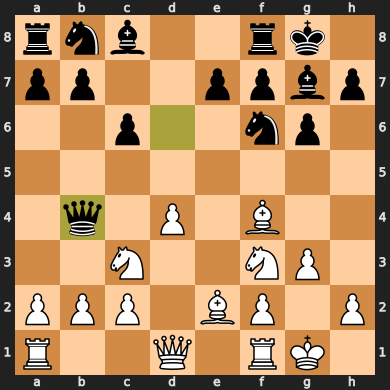

most recent valid board:


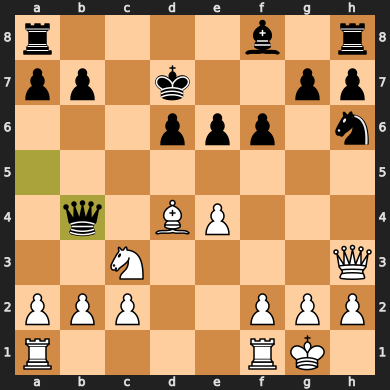

most recent valid board:


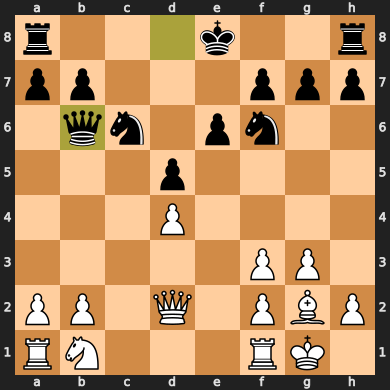

most recent valid board:


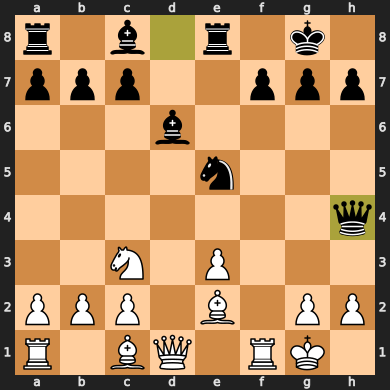

most recent valid board:


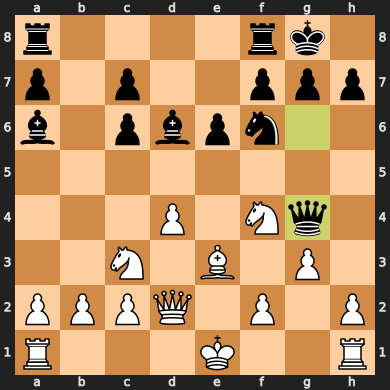

most recent valid board:


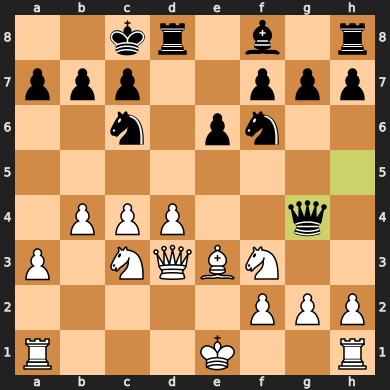

most recent valid board:


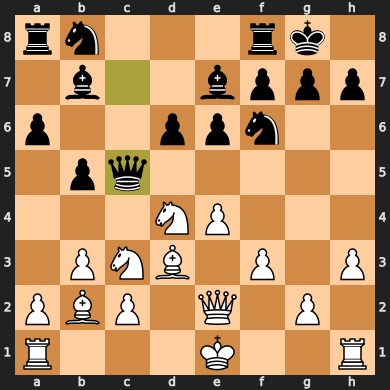

most recent valid board:


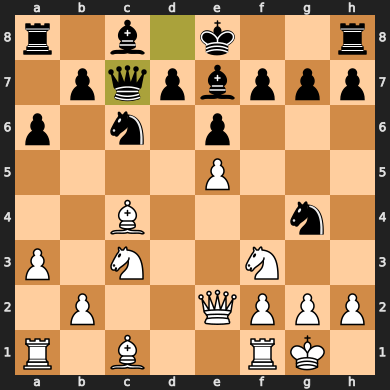

most recent valid board:


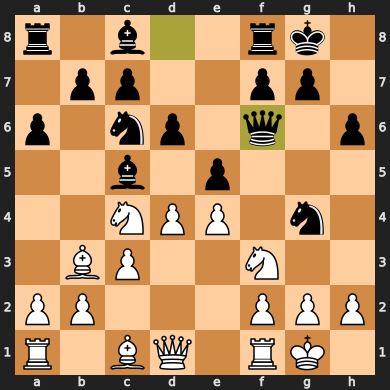

most recent valid board:


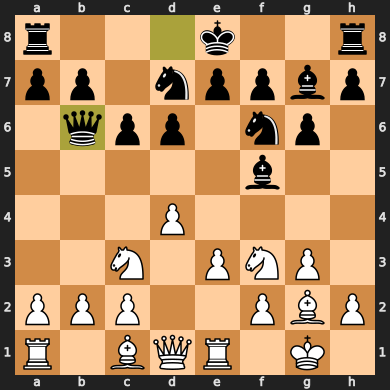

most recent valid board:


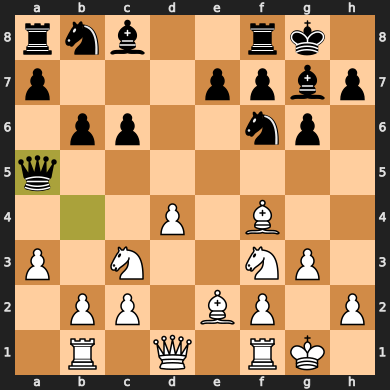

most recent valid board:


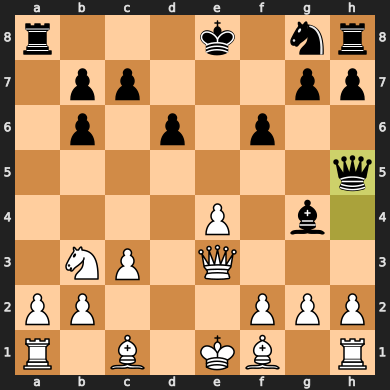

most recent valid board:


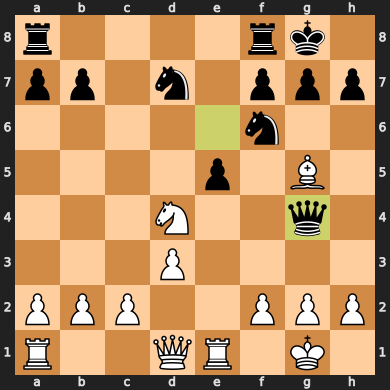

most recent valid board:


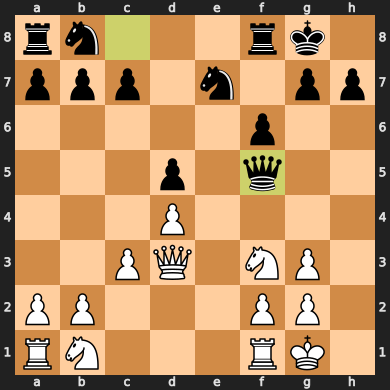

most recent valid board:


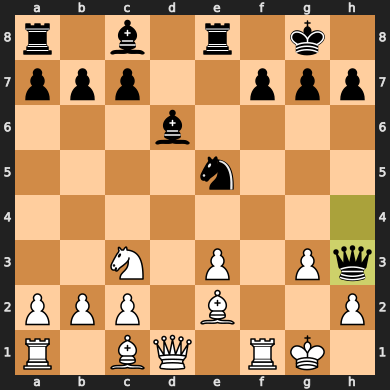

most recent valid board:


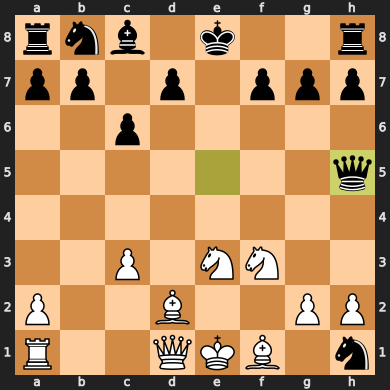

most recent valid board:


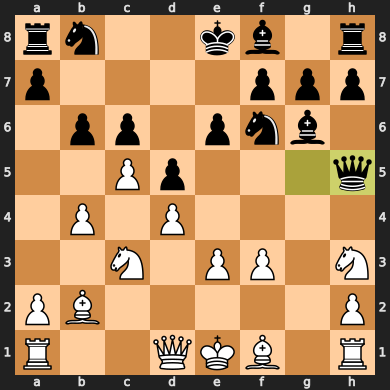

most recent valid board:


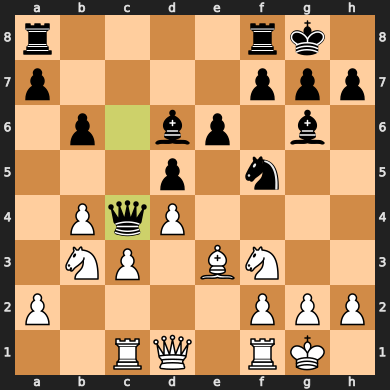

most recent valid board:


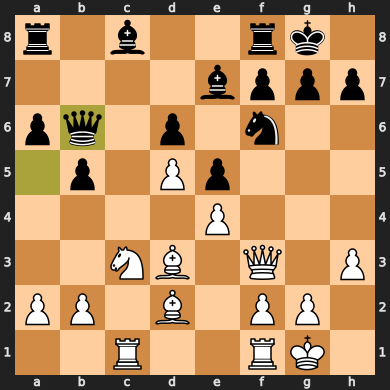

most recent valid board:


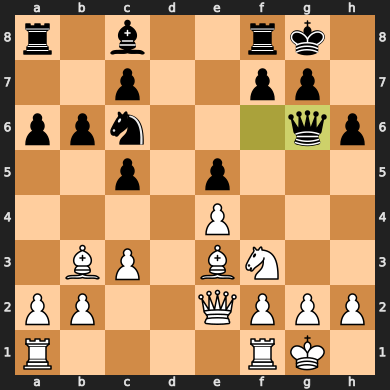

In [56]:
# set idx to be the index of the (alive) feature you want to visualize
idx = 4
feat_idx = results['alive_features'][idx]
print("Board states that the feature classifies according to Adam's measurements:")
print((results['board_to_piece_state'][0][idx] > .95).nonzero())
print("Number of such board states:")
print((results['board_to_piece_state'][0][idx] > .95).sum())
visualize(model, ae, buffer, feat_idx, k=20)